<a href="https://colab.research.google.com/github/smanouab/Data_access/blob/main/Probabilistic_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Programming
Bu-Ali Sina University, April 1, 2021

In [ ]:
!pip install pyro-ppl

In [ ]:
import torch
import torch.nn as nn
import pyro
import time
from torch.distributions import constraints
from pyro.distributions import Normal, Poisson, Exponential, Bernoulli
from pyro.infer import Trace_ELBO
from pyro.infer import MCMC, NUTS, SVI
from pyro.optim import RMSprop
import matplotlib.pyplot as plt

## Stochastic Hello World

### Poisson Hello World

In [ ]:
def stochastic_hello_world():
    n = pyro.sample('n', Poisson(1.0)).int()
    for i in range(n):
        print('Hello World!')
stochastic_hello_world()

### Exponential Hello World

In [ ]:
def stochastic_hello_world():
    t = pyro.sample('t', Exponential(0.5))
    time.sleep(t)
    print('Hello World after {:.2f} seconds'.format(t))
stochastic_hello_world()

Hello World after 0.01 seconds


### Markovian Arrival Hello World!

In [ ]:
def stochastic_hello_world():
    n = pyro.sample('n', Poisson(4.0)).int()
    for i in range(n):
        t = pyro.sample('t_{}'.format(i), Exponential(0.5))
        time.sleep(t)
        print('Hello World after {:.2f} seconds'.format(t))
stochastic_hello_world()

Hello World after 1.51 seconds
Hello World after 2.42 seconds
Hello World after 3.24 seconds
Hello World after 1.37 seconds


## Bayesian Linear Regression

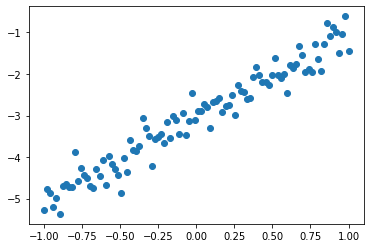

In [ ]:
X = torch.linspace(-1, 1, 100).view(-1, 1)
y = 2*X - 3 + torch.normal(0, 0.3, size=X.shape)
_ = plt.scatter(X, y)

### Model Definition

In [ ]:
def bayesian_regression(X, y):
  alpha = pyro.sample('alpha', Normal(0.0, 3.0))
  beta = pyro.sample('beta', Normal(0.0, 3.0))

  with pyro.plate('data'):
    pyro.sample('y',
                Normal(alpha*X+beta, 1.0).to_event(1), obs=y)

### Infrence using Markov Chain Monte Carlo

In [ ]:
nuts_kernel = NUTS(bayesian_regression, jit_compile=True)
mcmc = MCMC(nuts_kernel,
                num_samples=5000,
                warmup_steps=300)
mcmc.run(X, y)

Sample: 100%|██████████| 5300/5300 [00:23, 222.36it/s, step size=9.50e-01, acc. prob=0.914]


In [ ]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.00      0.17      2.00      1.73      2.27   4843.27      1.00
      beta     -3.04      0.10     -3.04     -3.20     -2.89   4554.27      1.00

Number of divergences: 0


In [ ]:
mcmc.get_samples()

{'alpha': tensor([1.7783, 2.0674, 2.0498,  ..., 2.0150, 1.7935, 1.9694]),
 'beta': tensor([-2.8799, -3.1618, -2.9640,  ..., -2.9586, -3.0031, -2.8473])}

### Inferene using Stochastic Variational Inference

#### Variational Distribution Definition

In [ ]:
def guide(X, y):
  alpha_mu = pyro.param('alpha_mu', torch.tensor(0.0))
  alpha_sigma = pyro.param('alpha_sigma', torch.tensor(1.0),
                           constraint=constraints.positive)
  beta_mu = pyro.param('beta_mu', torch.tensor(0.0))
  beta_sigma = pyro.param('beta_sigma', torch.tensor(1.0),
                          constraint=constraints.positive)

  pyro.sample('alpha', Normal(alpha_mu, alpha_sigma))
  pyro.sample('beta', Normal(beta_mu, beta_sigma))

#### Minimizing ELBO using RMSProp

In [ ]:
pyro.clear_param_store()
optimizer = RMSprop({"lr": 0.2})
svi = SVI(bayesian_regression, guide,
          optimizer, loss=Trace_ELBO())

loss = []
n_steps = 80
for step in range(n_steps):
  loss.append(svi.step(X, y))

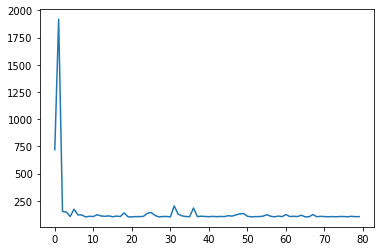

In [ ]:
_ = plt.plot(loss)

In [ ]:
alpha_mu = pyro.param('alpha_mu').item()
alpha_sigma = pyro.param('alpha_sigma').item()

beta_mu = pyro.param('beta_mu').item()
beta_sigma = pyro.param('beta_sigma').item()

print('alpha : mu : {:.2f} | sigma : {:.2f}'.format(alpha_mu, alpha_sigma))
print('beta : mu : {:.2f} | sigma : {:.2f}'.format(beta_mu, beta_sigma))

alpha : mu : 1.91 | sigma : 0.45
beta : mu : -2.96 | sigma : 0.08
